In [1]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from fastprogress.fastprogress import master_bar, progress_bar
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from compressai.models import CompressionModel
from compressai.entropy_models import EntropyBottleneck
from compressai.layers import GDN1

In [2]:
vimeo6k_dino = load_dataset("danjacobellis/vimeo6k_dino",split='train').with_format("torch")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
def conv(in_channels, out_channels, kernel_size=5, stride=2, groups=32):
    return nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
        groups=groups
    )

In [4]:
def deconv(in_channels, out_channels, kernel_size=5, stride=2, groups=32):
    return nn.ConvTranspose2d(
        in_channels,
        out_channels,
        kernel_size=kernel_size,
        stride=stride,
        output_padding=stride - 1,
        padding=kernel_size // 2,
        groups=groups
    )

In [6]:
class RateDistortionAutoEncoder(CompressionModel):
    def __init__(self, N=4096):
        super().__init__()
        self.entropy_bottleneck = EntropyBottleneck(N)
        self.encode = nn.Sequential(
            conv(1536, N, kernel_size=1, stride=1),
            GDN1(N),
            conv(N, N, kernel_size=5, stride=2),
            GDN1(N),
            conv(N, N, kernel_size=5, stride=2),
        )

        self.decode = nn.Sequential(
            deconv(N, N, kernel_size=5, stride=2),
            GDN1(N, inverse=True),
            deconv(N, N, kernel_size=5, stride=2),
            GDN1(N, inverse=True),
            deconv(N, 1536, kernel_size=1, stride=1),
        )

    def forward(self, x):
        y = self.encode(x)
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        x_hat = self.decode(y_hat)
        return x_hat, y_likelihoods

In [7]:
λ = 0.1
net = RateDistortionAutoEncoder().to("cuda")
parameters = set(p for n, p in net.named_parameters() if not n.endswith(".quantiles"))
aux_parameters = set(p for n, p in net.named_parameters() if n.endswith(".quantiles"))
optimizer = optim.AdamW(parameters, lr=1e-3)
aux_optimizer = optim.AdamW(aux_parameters, lr=1e-3)

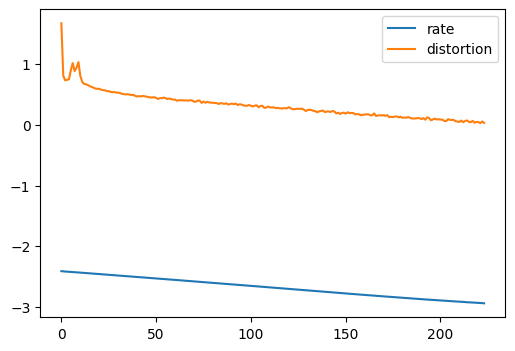

In [ ]:
rate = np.array([])
distortion = np.array([])
epochs = 200
mb = master_bar(range(1, epochs+1))
mb.names = ['rate', 'distortion']
train_loss, valid_loss = [], []
for epoch in mb:
    dataloader = DataLoader(vimeo6k_dino, batch_size=80, shuffle=True, drop_last=True)
    for batch in progress_bar(dataloader, parent=mb):

        optimizer.zero_grad()
        aux_optimizer.zero_grad()
        
        x = batch['patch_tokens'].squeeze(1)[:,:,1:-1,:].to("cuda")

        x_hat, y_likelihoods = net(x)
        
        N, C, H, W = x.size()
        num_samples = N * C * H * W
        bps_loss = torch.log(y_likelihoods).sum() / (-np.log(2) * num_samples)
        rate = np.append(rate, λ*bps_loss.detach().cpu().numpy())
        
        mse_loss = F.mse_loss(x, x_hat)
        distortion = np.append(distortion,mse_loss.detach().cpu().numpy())
        
        loss = mse_loss + λ*bps_loss
        loss.backward()
        optimizer.step()
        aux_loss = net.aux_loss()
        aux_loss.backward()
        aux_optimizer.step()

        graphs = [[range(len(rate)),np.log(rate)], [range(len(distortion)),np.log(distortion)]]
        mb.update_graph(graphs)
    torch.save({
        'epoch': epoch,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'aux_optimizer_state_dict': aux_optimizer.state_dict(),
        'rate': rate,
        'distortion': distortion
    }, f"checkpoint_dino_rdae_{epoch}.pth")